In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import *
import wandb

In [2]:
class model_encoder(nn.Module):
    def __init__(self):
        super(model_encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 5, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 1, stride=1, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 5, stride=1, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 1, stride=1, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 4, stride=1, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 1, stride=1, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
        )
 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 16, 1, stride=1, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, 5, stride=2, padding=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 8, 1, stride=1, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 4, 4, stride=1, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(4),
            nn.ConvTranspose2d(4, 4, 1, stride=1, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(4),
            nn.ConvTranspose2d(4, 1, 3, stride=1, padding=0),
        )
        
    def forward(self, x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x

In [3]:
batch_size = 128
board=np.load('board.npy')/1000
board=torch.tensor(board, dtype=torch.float32)
board=torch.reshape(board, (board.shape[0],1, 32,32))
board=TensorDataset(board) 
train_dataset, test_dataset = random_split(board, [650000, 40288])
dataset=DataLoader(board,  batch_size=batch_size, shuffle=True, pin_memory=True)

In [4]:
num_epochs = 4
learning_rate = 1e-3
momentum = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model_encoder().to(device)
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)#, momentum=momentum)
#optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn=torch.nn.BCEWithLogitsLoss()

In [ ]:
sched=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5078,.05,-1)

In [ ]:
wandb.init(project="halite")
wandb.watch(model)
model.train()
j=0
for i in range(num_epochs):
    print(i+1, "of", num_epochs)
    for data in dataset:
        data=data[0].to(device)
        res=model(data)
        optimizer.zero_grad()
        loss=loss_fn(res,data)
        loss.backward()
        optimizer.step()
        sched.step()
        for g in optimizer.param_groups:
            lr_res=g['lr']
        wandb.log({"Loss": loss, "LR":lr_res })
        j+=1

In [ ]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(5):
    j=np.random.randint(0,40288)
    img=model(test_dataset[j][0].unsqueeze(1).to(device))
    plt.subplot(5,2,2*i+1)
    plt.imshow(test_dataset[j][0].squeeze(0).cpu().numpy())
    plt.subplot(5,2,2*i+2)
    plt.imshow(torch.reshape(img,(32,32)).detach().cpu().numpy())
plt.tight_layout()

In [ ]:
len(test_dataset)

In [5]:
def learning_rate_finder():
    loss_res=[]
    lr_ls=[]
    lr=1e-5
    j=0
    for g in optimizer.param_groups:
            g['lr'] = lr
    for data in dataset:
        data=data[0].to(device)
        res=model(data)
        optimizer.zero_grad()
        loss=loss_fn(res,data)
        loss.backward()
        optimizer.step()
        loss_res.append(loss.cpu().detach().numpy())
        lr_ls.append(lr)
        lr= 1e-5 * (1.011 ** j)
        for g in optimizer.param_groups:
            g['lr'] = lr
        j+=1
        if loss>np.min(loss_res)*4:
            return lr_ls,loss_res

Text(0.5, 1.0, 'Learning Rate Finder')

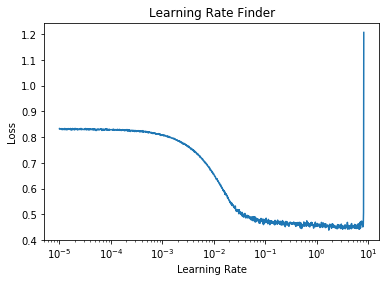

In [6]:
lr_ls,res=learning_rate_finder()
plt.semilogx(lr_ls[:-1],res[:-1])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Finder')